# Prophet + 23 regressor (1, 7, 30 kunlik forecast)

- Target: `rate`; `date` tashlanadi; qolgan 23 ustun regressorga beriladi.
- Outlier clip (IQR), 70/15/15 split, MAE/MAPE.
- 1/7/30 kunlik forecast: agar kelajak featurelar mavjud bo'lmasa, oxirgi qatordagi qiymatlar takrorlanadi.


In [1]:
print('hi')

hi


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [9]:
# Ma'lumotlarni yuklash
p = Path('datasets/usd_rates_ready.csv')
df = pd.read_csv(p)
df.columns = [c.lower() for c in df.columns]
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

# Target = rate, date ishlatilmaydi, qolgan 23 ta ustun feature sifatida
feature_cols = [c for c in df.columns if c not in ['date', 'rate']]

# Outlierlarni IQR bilan yumshatish (faqat targetda)
'''
def clip_iqr(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k * iqr, q3 + k * iqr
    return s.clip(lower, upper)

df['rate'] = clip_iqr(df['rate'])
'''

# Vaqt bo'yicha train/val/test (70/15/15)
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)
train_df = df.iloc[:train_end]
val_df = df.iloc[train_end:val_end]
test_df = df.iloc[val_end:]

# Bashorat kunlari
horizons = [1, 7, 30]

try:
    from prophet import Prophet
except ImportError:
    raise SystemExit("Prophet o'rnatilmagan: pip install prophet")

train_p = train_df[['date', 'rate'] + feature_cols].rename(columns={'date': 'ds', 'rate': 'y'})
val_p = val_df[['date', 'rate'] + feature_cols].rename(columns={'date': 'ds', 'rate': 'y'})
test_p = test_df[['date', 'rate'] + feature_cols].rename(columns={'date': 'ds', 'rate': 'y'})

prophet = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
for col in feature_cols:
    prophet.add_regressor(col)

# Train
prophet.fit(train_p)


08:58:10 - cmdstanpy - INFO - Chain [1] start processing
08:58:12 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Val/test baholash
val_forecast = prophet.predict(val_p)
test_forecast = prophet.predict(test_p)

val_pred = val_forecast['yhat']
test_pred = test_forecast['yhat']

mae_val = mean_absolute_error(val_p['y'], val_pred)
rmse_val = root_mean_squared_error(val_p['y'], val_pred)
r2_score_val = r2_score(val_p['y'], val_pred)
print(val_p['y'], val_pred)

mae_test = mean_absolute_error(test_p['y'], test_pred)
rmse_test = root_mean_squared_error(test_p['y'], test_pred)
r2_score_test = r2_score(test_p['y'], test_pred)

print(f"Vali MAE: {mae_val:.2f}, RMSE: {rmse_val:.4f}, R2 Score: {r2_score_val:.4f}")
print(f"Test MAE: {mae_test:.2f}, RMSE: {rmse_test:.4f}, R2 Score: {r2_score_test:.4f}")


1800    12228.05
1801    12219.23
1802    12234.42
1803    12249.00
1804    12240.01
          ...   
2181    12808.03
2182    12800.13
2183    12800.13
2184    12800.13
2185    12812.30
Name: y, Length: 386, dtype: float64 0      12223.032760
1      12224.290997
2      12228.065816
3      12245.562396
4      12239.883294
           ...     
381    12811.138903
382    12810.609443
383    12802.654880
384    12800.174881
385    12810.951519
Name: yhat, Length: 386, dtype: float64
Vali MAE: 7.39, RMSE: 9.3798, R2 Score: 0.9966
Test MAE: 16.18, RMSE: 21.6833, R2 Score: 0.9962


In [11]:
# 1/7/30 kunlik forecast 
last_feat = df[feature_cols].iloc[-1]
horizon_forecasts = {}
for h in horizons:
    future_dates = pd.date_range(df['date'].max() + pd.Timedelta(days=1), periods=h, freq='D')
    future_reg = pd.DataFrame(np.repeat([last_feat.values], h, axis=0), columns=feature_cols)
    future_df = pd.concat([pd.DataFrame({'ds': future_dates}), future_reg], axis=1)
    fc = prophet.predict(future_df)
    horizon_forecasts[f'h_{h}'] = fc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Namuna chiqishi
horizon_forecasts['h_30'].head(10)

,ds,yhat,yhat_lower,yhat_upper
0,2025-12-10,12027.243876,12007.544614,12046.575919
1,2025-12-11,12080.568960,12060.283650,12100.280223
2,2025-12-12,12134.034115,12114.115196,12154.186419
3,2025-12-13,11742.605245,11721.400097,11761.128396
4,2025-12-14,11794.000877,11773.485103,11814.408401
5,2025-12-15,11918.701344,11899.693031,11939.686333
6,2025-12-16,11976.841794,11960.176312,11997.773459
7,2025-12-17,12028.238099,12009.745368,12048.128954
8,2025-12-18,12081.768656,12060.672909,12100.864334
9,2025-12-19,12135.421957,12116.712047,12154.722410


### Bashorat natijalari haqida
- yhat: modelning markaziy bashorati (kutilgan qiymat).
- yhat_lower: pastki ishonch cheklovi (Prophet default interval_width=0.8, ya'ni ~80% interval).
- yhat_upper: yuqori ishonch cheklovi; bashorat noaniqligi kengligini ko'rsatadi.

Quyidagi grafik 7 kunlik bashoratni ko'rsatadi; boshqa ufqlar uchun h_1, h_7, h_30 ni ishlatish mumkin.


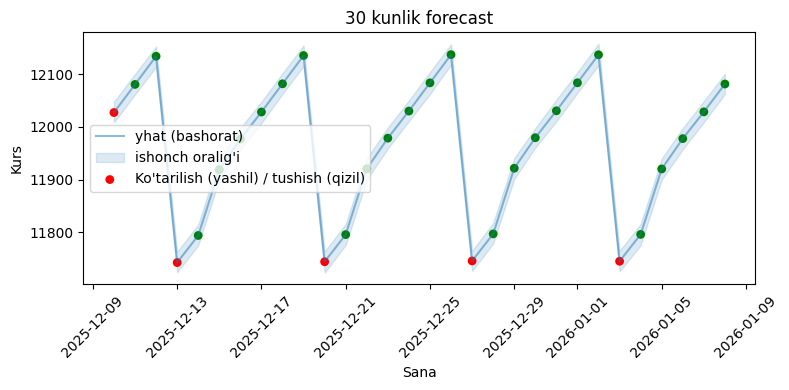

In [8]:
# Bashoratni vizualizatsiya qilish
import matplotlib.pyplot as plt

def plot_forecast(h_key='h_7', title='7 kunlik forecast'):  # h_key: 'h_1', 'h_7', 'h_30'
    fc_df = horizon_forecasts[h_key].sort_values('ds').copy()
    fc_df['delta'] = fc_df['yhat'].diff()

    plt.figure(figsize=(8, 4))
    plt.plot(fc_df['ds'], fc_df['yhat'], label='yhat (bashorat)', color='C0', alpha=0.5)
    plt.fill_between(fc_df['ds'], fc_df['yhat_lower'], fc_df['yhat_upper'], color='C0', alpha=0.15, label='ishonch oralig\'i')

    inc_mask = fc_df['delta'] >= 0
    colors = np.where(inc_mask, 'green', 'red')
    plt.scatter(fc_df['ds'], fc_df['yhat'], c=colors, edgecolor='none', s=40, label='Ko\'tarilish (yashil) / tushish (qizil)')

    plt.title(title)
    plt.xlabel('Sana')
    plt.ylabel('Kurs')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Default: 7 kunlik forecast
plot_forecast('h_30', '30 kunlik forecast')
